In [1]:
###-----------------
### Import libraries
###-----------------
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.model_selection import  train_test_split # Import function to split dataset into training and testing subsets
from sklearn.metrics import * # Import function to calculate various metric

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os


In [2]:
###----------------------
### Some basic parameters
###----------------------

inpDir = Path('..') / '..' / 'input'
outDir = Path('..') / 'output'
modelDir = Path('..') / 'models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 100 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
# TRAIN_SIZE=int(18*BATCH_SIZE)


WEIGHT_DECAY = 0.001
PATENCE = 20
LR_FACTOR = 0.1
LR_PATIENCE = 5
MIN_LR = 1e-6

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Data Generation

In [3]:
data_dir = r"D:\dnn_input\flower_photos"
# 2. Define parameters for image loading
IMAGE_SIZE = (190, 190) # Standardize image dimensions
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2 # 20% of the data will be used for validation

train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20, # Rotate images randomly by up to 20 degrees
    width_shift_range=0.2, # Shift images horizontally by up to 20%
    height_shift_range=0.2, # Shift images vertically by up to 20%
    shear_range=0.2, # Apply shear transformation
    zoom_range=0.2, # Zoom in on images
    horizontal_flip=True, # Flip images horizontally
    fill_mode='nearest', # Strategy for filling in new pixels created by rotation/shift
    validation_split=VALIDATION_SPLIT # THIS IS KEY for the split
)

# Load the training images from the directory
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    subset='training', # Specify this is the training set
    seed=42 # Set a seed for reproducibility
)


validation_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
    validation_split=VALIDATION_SPLIT # THIS IS KEY for the split
)

# Load the validation images from the directory
validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation', # Specify this is the validation set
    seed=42 # Use the same seed for consistent splitting
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


## MOdel Build

In [4]:
def build_model(input_shape, num_classes):
    model=tf.keras.Sequential()

    model.add(tf.keras.Input(shape=input_shape))
    #model.add(tf.keras.layers.Rescaling(1./255))
    

    ##SET-1
    model.add(tf.keras.layers.Conv2D(32,(3,3),padding='same'))#(188x188x32)
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D())#(94x94x32)

    ##SET-2
    model.add(tf.keras.layers.Conv2D(64,(3,3)))#(92x92x64)
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D())#(46x46x64)

    ##SET-3
    model.add(tf.keras.layers.Conv2D(128,(3,3)))#(44x44x128)
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D())#(22x22x128)

    ##SET-4
    model.add(tf.keras.layers.Conv2D(256,(3,3)))#(20x20x256)
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D())#(10x10x256)

    ##SET-5
    model.add(tf.keras.layers.Conv2D(512,(3,3)))#(8x8x512)
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.MaxPool2D())#(4x4x512)

    ##SET-6
    model.add(tf.keras.layers.Conv2D(1024,(3,3)))#(2x2x1024)
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Flatten())#4096

    ##HEAD
    model.add(tf.keras.layers.Dense(1024))#1024
    model.add(tf.keras.layers.ReLU())

    model.add(tf.keras.layers.Dense(num_classes))

    return model

In [5]:
IMAGE_HEIGHT =190
IMAGE_WIDTH =190
model = build_model([IMAGE_HEIGHT,IMAGE_WIDTH,3],train_generator.num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 190, 190, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 190, 190, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 95, 95, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 93, 93, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 93, 93, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 44, 44, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 2, 2, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,488,645 (40.01 MB)

 Trainable params: 10,488,645 (40.01 MB)

 Non-trainable params: 0 (0.00 B)

## callBacks

In [6]:
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=MIN_LR,
)

es_callback = tf.keras.callbacks.EarlyStopping(

    monitor="val_loss",
    min_delta=0,
    patience=PATENCE,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(ALPHA),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history= model.fit(train_generator,
                   validation_data=validation_generator,
                   epochs=EPOCHS,callbacks=[es_callback,lr_callback])

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.3726 - loss: 1.4388 - val_accuracy: 0.4378 - val_loss: 1.3366 - learning_rate: 0.0010
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 786ms/step - accuracy: 0.5271 - loss: 1.1326 - val_accuracy: 0.5732 - val_loss: 1.0424 - learning_rate: 0.0010
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 71s 767ms/step - accuracy: 0.5822 - loss: 1.0151 - val_accuracy: 0.6101 - val_loss: 0.9604 - learning_rate: 0.0010
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 760ms/step - accuracy: 0.6159 - loss: 0.9716 - val_accuracy: 0.5882 - val_loss: 1.1854 - learning_rate: 0.0010
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 753ms/step - accuracy: 0.6553 - loss: 0.8776 - val_accuracy: 0.6005 - val_loss: 1.0231 - learning_rate: 0.0010
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 761ms/step - accuracy: 0.6512 - loss: 0.9191 - val_accuracy: 0.6539 - val_loss: 0.9264 - learning_rate: 0.0010
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 70s 760ms/step - accuracy: 0.6761 - los

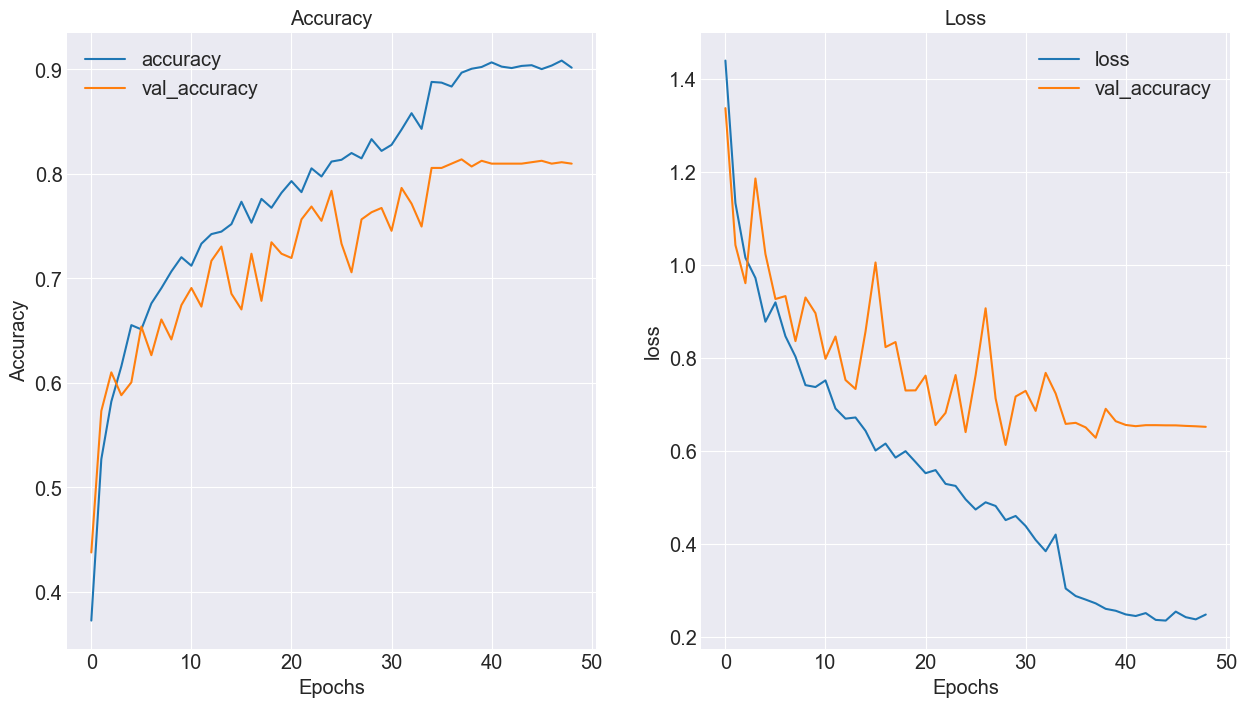

In [9]:
def plot_graph(history):
    fig,ax = plt.subplots(1,2,figsize=(15,8))
    keys=list(history.history.keys())
    ax[0].plot(history.epoch,history.history[keys[0]],label=keys[0])
    ax[0].plot(history.epoch,history.history[keys[2]],label=keys[2])
    ax[0].set_title('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.epoch,history.history[keys[1]],label=keys[1])
    ax[1].plot(history.epoch,history.history[keys[3]],label=keys[2])
    ax[1].set_title('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_graph(history)